This notebook focuses on classifying human and AI generated text using xlassical ML algorithm (RF, LR, SVM,...) \\
  Project: this notebook contribute to a part of the CW of AML module, MSc CS&AI   \\
Author: Fouzia Shile


# Import libraries

In [ ]:
!pip install keras-core --upgrade # deep learning library
!pip install -q keras-nlp # for NLP tasks like tokenization
!pip install seaborn # for plotting
import numpy as np
import pandas as pd
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import tensorflow as tf
import keras_core as keras

import keras_nlp
import seaborn as sns
import matplotlib.pyplot as plt


import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 10.1 MB/s eta 0:00:00
Using TensorFlow backend


# Load the dataset


In [ ]:
df1 = pd.read_csv('dforiginal.csv') # this is the first dataset with few samples
df2 = pd.read_csv('detectAItext.csv') # this is the 2nd dataset with new prompts and new LLMs,...


In [ ]:
print('size of df1 is: ', df1.shape)
print('size of df2 is: ', df2.shape)


size of df1 is:  (1378, 4)
size of df2 is:  (44868, 5)


In [ ]:
df1.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [ ]:
df2.head()

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


Text(0.5, 1.0, 'Distribution of prompt ID')

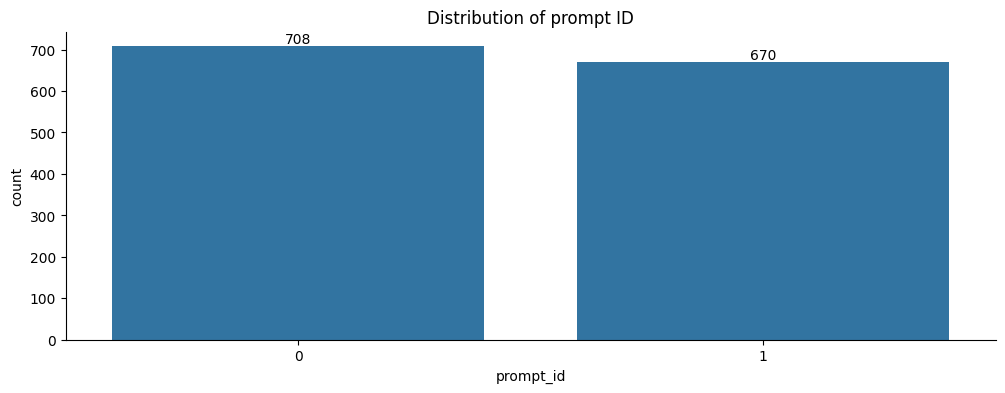

In [ ]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df1,
                   x="prompt_id")

abs_values = df1['prompt_id'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of prompt ID")

Text(0.5, 1.0, 'Distribution of prompt name')

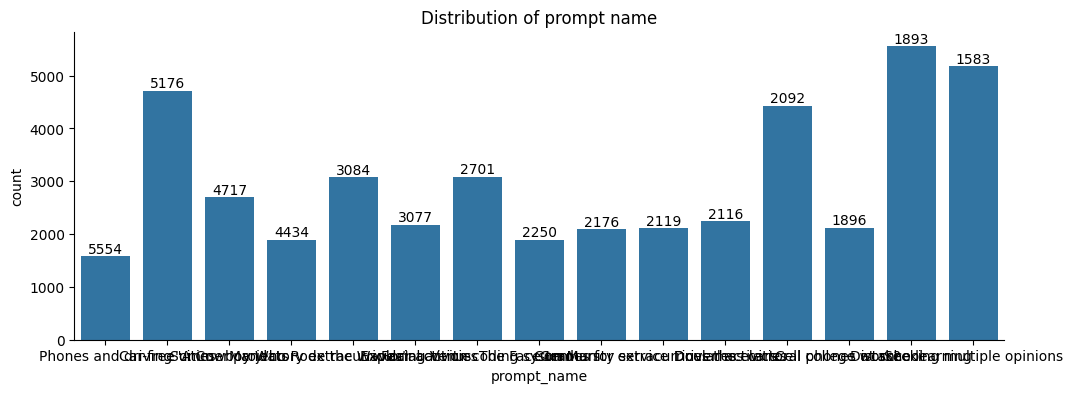

In [ ]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df2,
                   x="prompt_name")

abs_values = df2['prompt_name'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of prompt name")

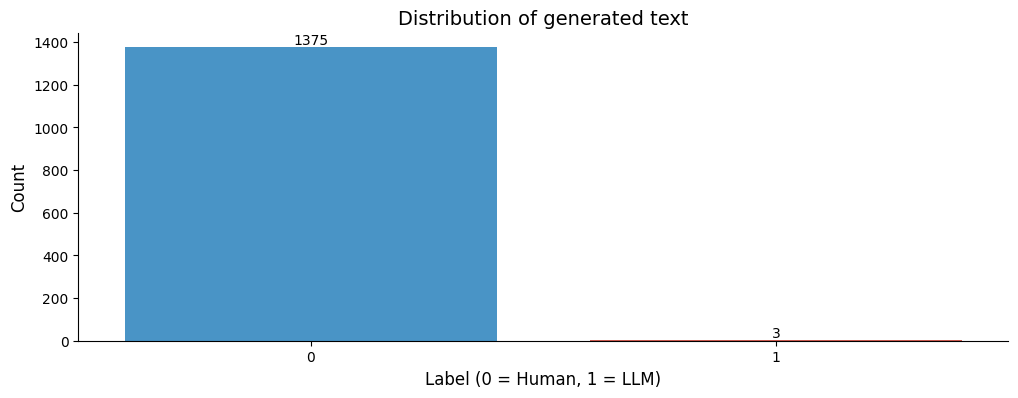

In [ ]:
# distribution of the  text essays in the original dataset
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()


ax = sns.countplot(
    data=df1,
    x="generated",
    hue="generated",
    palette=["#3498db", "#e74c3c"],
    legend=False
)


for container in ax.containers:
    ax.bar_label(container)


ax.set_title("Distribution of generated text", fontsize=14)
ax.set_xlabel("Label (0 = Human, 1 = LLM)", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

plt.show()

Rename label in the 2nd data to generated in order to match the 1st data column

In [ ]:
df2.rename(columns = {"label":"generated"}, inplace=True)

df2.info()
df2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44868 entries, 0 to 44867
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           44868 non-null  object
 1   generated      44868 non-null  int64 
 2   prompt_name    44868 non-null  object
 3   source         44868 non-null  object
 4   RDizzl3_seven  44868 non-null  bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 1.4+ MB


,text,generated,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


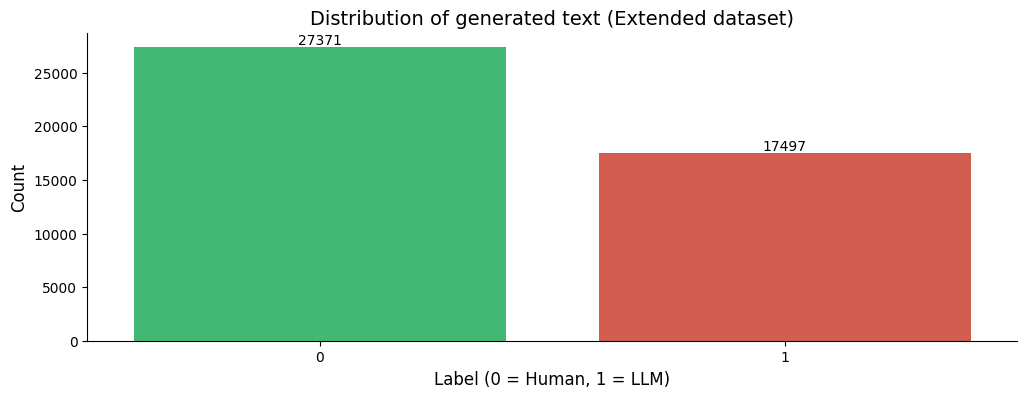

In [ ]:

# distribution of text essays in the extended dataset
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()

ax = sns.countplot(
    data=df2,
    x="generated",
    hue="generated",        #
    palette=["#2ecc71", "#e74c3c"],
    legend=False
)


for container in ax.containers:
    ax.bar_label(container)


ax.set_title("Distribution of generated text (Extended dataset)", fontsize=14)
ax.set_xlabel("Label (0 = Human, 1 = LLM)", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

plt.show()


### Concatenate the 2 datasets

**Next, we concatenate them together. Now we only care about the text and the label that is generated by AI or not.**

Combine both datasets into one final training set

In [ ]:
df_final = pd.concat([df2[["text", "generated"]], df1[["text", "generated"]]])

df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46246 entries, 0 to 1377
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       46246 non-null  object
 1   generated  46246 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [ ]:
# Save the concatenated df to a csv file
df_final.to_csv('concatenated_dataset.csv', index=False)


In [ ]:
# Read it to verify
df_check = pd.read_csv('concatenated_dataset.csv')
print(df_check.head())


                                                text  generated
0  Phones\n\nModern humans today are always on th...          0
1  This essay will explain if drivers should or s...          0
2  Driving while the use of cellular devices\n\nT...          0
3  Phones & Driving\n\nDrivers should not be able...          0
4  Cell Phone Operation While Driving\n\nThe abil...          0


### Explore the final concatenated dataset

In [ ]:
df_final.shape

(46246, 2)

In [ ]:
df_final.head()

,text,generated
0,Phones\n\nModern humans today are always on th...,0
1,This essay will explain if drivers should or s...,0
2,Driving while the use of cellular devices\n\nT...,0
3,Phones & Driving\n\nDrivers should not be able...,0
4,Cell Phone Operation While Driving\n\nThe abil...,0


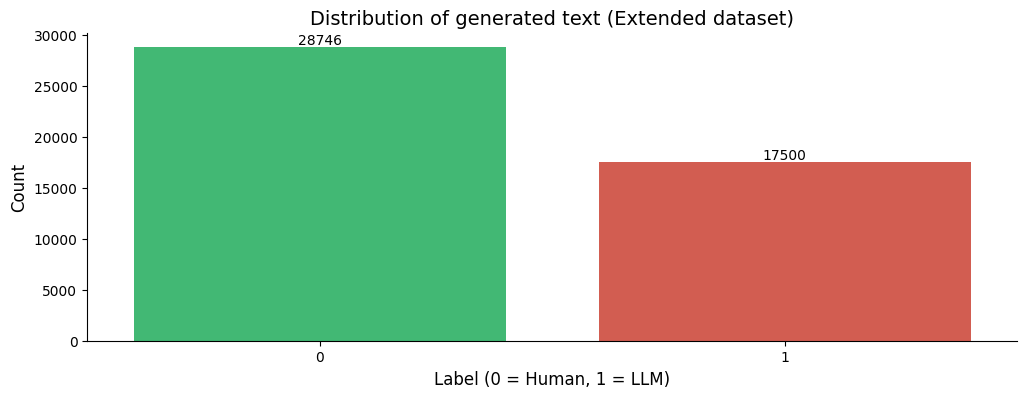

In [ ]:
# distribution of text essays in the concatinated final dataset

f, ax = plt.subplots(figsize=(12, 4))

sns.despine()

ax = sns.countplot(
    data=df_final,
    x="generated",
    hue="generated",        #
    palette=["#2ecc71", "#e74c3c"],
    legend=False
)


for container in ax.containers:
    ax.bar_label(container)

ax.set_title("Distribution of generated text (Extended dataset)", fontsize=14)
ax.set_xlabel("Label (0 = Human, 1 = LLM)", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

plt.show()

Text length distribution

Text length statistics:
count    46246.000000
mean      2244.614496
std        981.941658
min         48.000000
25%       1581.000000
50%       2070.000000
75%       2663.000000
max      18322.000000
Name: text_length, dtype: float64


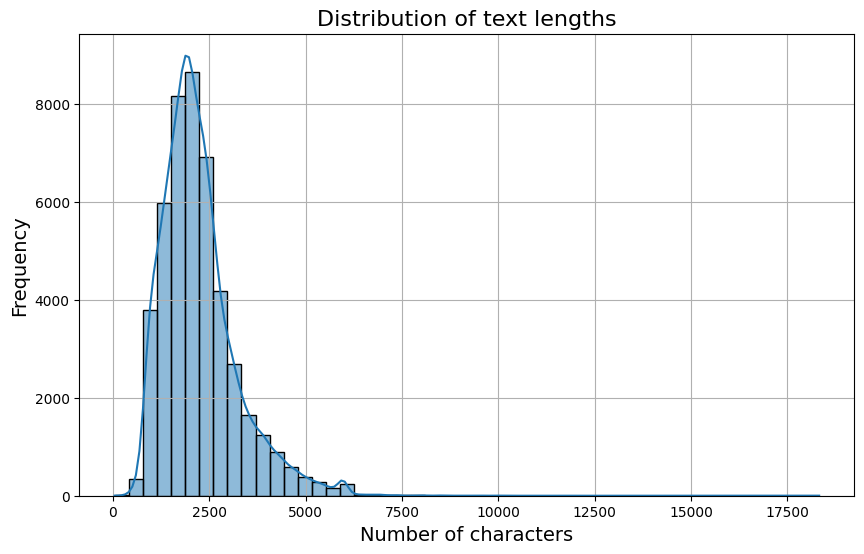

In [ ]:

df_final['text_length'] = df_final['text'].apply(len)


print("Text length statistics:")
print(df_final['text_length'].describe())


plt.figure(figsize=(10,6))
sns.histplot(df_final['text_length'], bins=50, kde=True)
plt.title('Distribution of text lengths', fontsize=16)
plt.xlabel('Number of characters', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()


Word count distribution \\
**Word count is often a better measure than character length for essays.**

Word count ctatistics:
count    46246.000000
mean       388.761428
std        167.367549
min          4.000000
25%        276.000000
50%        357.000000
75%        461.000000
max       1656.000000
Name: word_count, dtype: float64


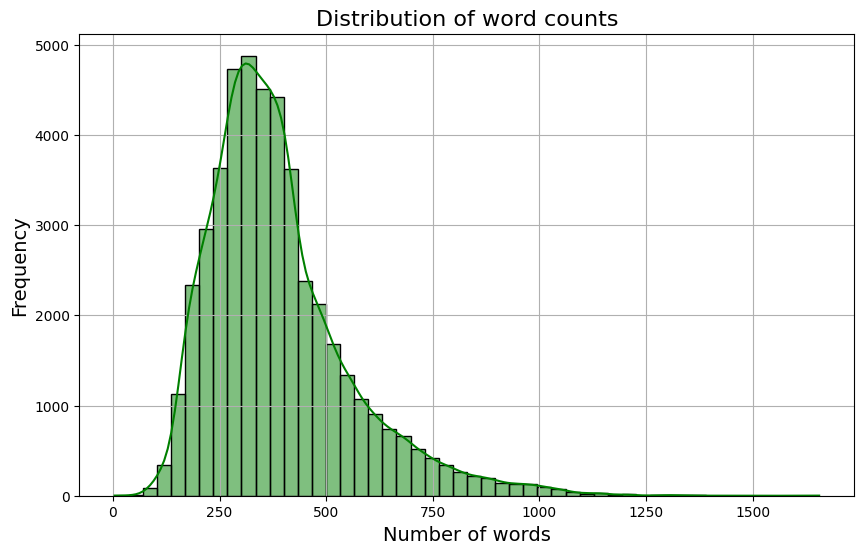

In [ ]:

df_final['word_count'] = df_final['text'].apply(lambda x: len(x.split()))


print("Word count ctatistics:")
print(df_final['word_count'].describe())

plt.figure(figsize=(10,6))
sns.histplot(df_final['word_count'], bins=50, kde=True, color='green')
plt.title('Distribution of word counts', fontsize=16)
plt.xlabel('Number of words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()


# Data preprocessing

## Data cleaning

In [ ]:


# download required resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # lowercase
    text = text.lower()
    # remove HTML tags, BTW in my dataset i don't have hashtags!
    text = re.sub(r'<.*?>', '', text)
    # remove URLs (no urls in this dataset )
    text = re.sub(r'http\S+|www\S+', '', text)
    # remove special characters and digits
    text = re.sub(r'[^a-z\s]', '', text)
    # tokenize
    tokens = text.split()
    # remove stopwords
    tokens = [w for w in tokens if w not in stop_words]
    # stemming and lemmatization
    tokens = [stemmer.stem(lemmatizer.lemmatize(w)) for w in tokens]
    return ' '.join(tokens)

# Apply preprocessing to the final combined dataset
df_final["clean_text"] = df_final["text"].apply(preprocess_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
#  Save cleaned dataset
df_final.to_csv('cleaned_dataset.csv', index=False)

In [ ]:
df_final.shape

(46246, 5)

In [ ]:
df_final.head()

,text,generated,text_length,word_count,clean_text
0,Phones\n\nModern humans today are always on th...,0,2029,379,phone modern human today alway phone alway pho...
1,This essay will explain if drivers should or s...,0,2141,366,essay explain driver abl use electron devic op...
2,Driving while the use of cellular devices\n\nT...,0,1044,178,drive use cellular devic today societi thought...
3,Phones & Driving\n\nDrivers should not be able...,0,1243,212,phone drive driver abl use phone oper vehicl d...
4,Cell Phone Operation While Driving\n\nThe abil...,0,1911,332,cell phone oper drive abil stay connect peopl ...


## Handle duplicates, missing values and noise

In [ ]:
#  Check for missing values
print("Missing values:\n", df_final.isnull().sum())

# Drop rows with missing text
df_final = df_final.dropna(subset=['clean_text']).reset_index(drop=True)

#  Check for duplicates
duplicates = df_final.duplicated(subset=['clean_text']).sum()
print(f"Number of duplicate texts: {duplicates}")

# Drop duplicates if any
df_final = df_final.drop_duplicates(subset=['clean_text']).reset_index(drop=True)

#  Remove very short essays. this is optional because in most papers it is not considered
#df_final['word_count'] = df_final['clean_text'].apply(lambda x: len(x.split()))
#df_final = df_final[df_final['word_count'] >= 10].reset_index(drop=True)

# check shape
print(f"Dataset shape after cleaning: {df_final.shape}")


Missing values:
 text           0
generated      0
text_length    0
word_count     0
clean_text     0
dtype: int64
Number of duplicate texts: 1457
Dataset shape after cleaning: (44789, 5)


"The dataset was enriched with additional fields, including a cleaned version of the text for machine learning tasks and a word count feature for exploratory analysis and noise filtering."

In [ ]:
df_final.head()

,text,generated,text_length,word_count,clean_text
0,Phones\n\nModern humans today are always on th...,0,2029,379,phone modern human today alway phone alway pho...
1,This essay will explain if drivers should or s...,0,2141,366,essay explain driver abl use electron devic op...
2,Driving while the use of cellular devices\n\nT...,0,1044,178,drive use cellular devic today societi thought...
3,Phones & Driving\n\nDrivers should not be able...,0,1243,212,phone drive driver abl use phone oper vehicl d...
4,Cell Phone Operation While Driving\n\nThe abil...,0,1911,332,cell phone oper drive abil stay connect peopl ...


## TF-IDF

In [ ]:


#  define features (X) and labels (y)
X = df_final['clean_text']
y = df_final['generated']

# initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,    # Limit to top 1000 words
    ngram_range=(1,2),    # Use unigrams and bigrams
    stop_words='english'  # remove english stopwords (even though i cleaned, just extra safety)
)

#  Fit and transform the text into TF-IDF features
X_tfidf = tfidf_vectorizer.fit_transform(X)

print(f"TF-IDF feature matrix shape: {X_tfidf.shape}")  # Should be (number of samples, 5000)

# train/test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y,
    test_size=0.2,
    random_state=42,
    stratify=y             # to maintain class balance in splits
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


TF-IDF feature matrix shape: (44789, 10000)
Training set shape: (35831, 10000)
Test set shape: (8958, 10000)


# Classical ML models training and evaluation

## Logistic reg

Classification report:
              precision    recall  f1-score   support

       Human       0.99      1.00      0.99      5459
         LLM       0.99      0.98      0.99      3499

    accuracy                           0.99      8958
   macro avg       0.99      0.99      0.99      8958
weighted avg       0.99      0.99      0.99      8958



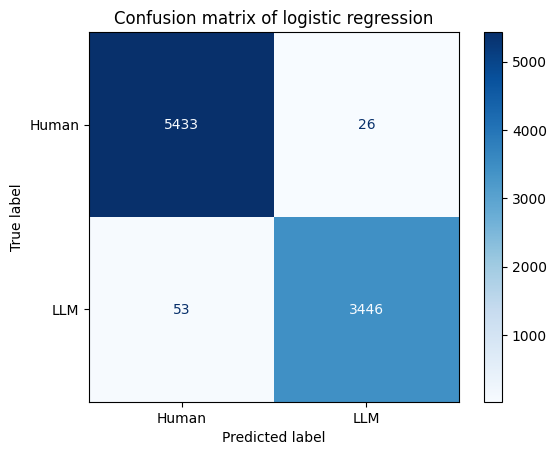

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# initialize LR with class_weight='balanced'
lr_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

# train the model
lr_model.fit(X_train, y_train)

# predict on the test set
y_pred = lr_model.predict(X_test)

# evaluate the model

print("Classification report:")
print(classification_report(y_test, y_pred, target_names=["Human", "LLM"]))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Human", "LLM"])
disp.plot(cmap='Blues')
plt.title('Confusion matrix of logistic regression')
plt.show()


## SVM

Classification Report (SVM):
              precision    recall  f1-score   support

       Human       0.99      1.00      0.99      5459
         LLM       0.99      0.99      0.99      3499

    accuracy                           0.99      8958
   macro avg       0.99      0.99      0.99      8958
weighted avg       0.99      0.99      0.99      8958



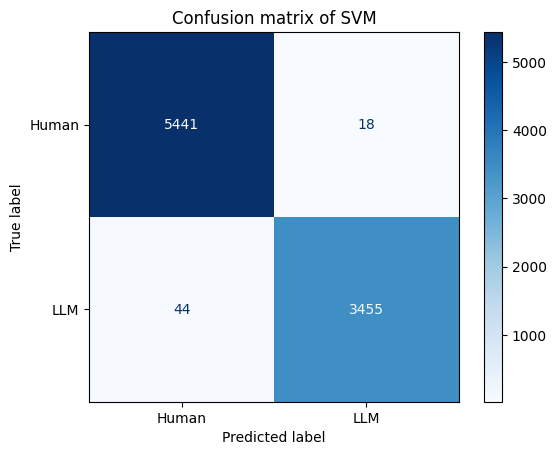

In [ ]:
from sklearn.svm import SVC


svm_model = SVC(class_weight='balanced', random_state=42, kernel='linear')

# train the model
svm_model.fit(X_train, y_train)

# predict on the test set
y_pred_svm = svm_model.predict(X_test)

# evaluate the model

print("Classification Report (SVM):")
print(classification_report(y_test, y_pred_svm, target_names=["Human", "LLM"]))

cm_svm = confusion_matrix(y_test, y_pred_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=["Human", "LLM"])
disp_svm.plot(cmap='Blues')
plt.title('Confusion matrix of SVM')
plt.show()


## Decision tree

Classification Report (Decision Tree):
              precision    recall  f1-score   support

       Human       0.94      0.94      0.94      5459
         LLM       0.91      0.90      0.91      3499

    accuracy                           0.93      8958
   macro avg       0.92      0.92      0.92      8958
weighted avg       0.93      0.93      0.93      8958



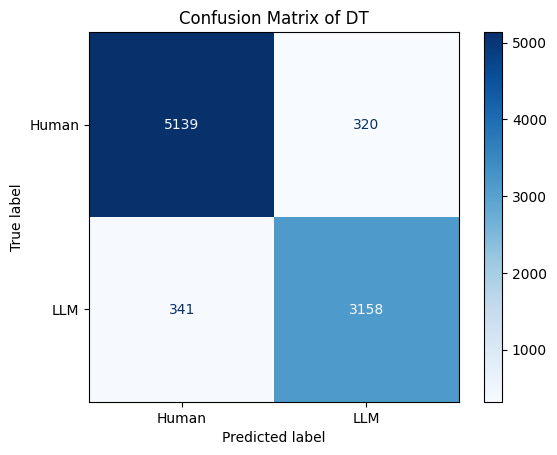

In [ ]:
from sklearn.tree import DecisionTreeClassifier


dt_model = DecisionTreeClassifier(
    class_weight='balanced',
    max_depth=30,              # to control overfittting
    random_state=42
)

# train the model
dt_model.fit(X_train, y_train)

# predict on the test set
y_pred_dt = dt_model.predict(X_test)

# evaluate the model
print("Classification Report (Decision Tree):")
print(classification_report(y_test, y_pred_dt, target_names=["Human", "LLM"]))

cm_dt = confusion_matrix(y_test, y_pred_dt)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=["Human", "LLM"])
disp_dt.plot(cmap='Blues')
plt.title('Confusion Matrix of DT')
plt.show()


##Random Forest

Classification Report (Random Forest):
              precision    recall  f1-score   support

       Human       0.98      0.99      0.99      5459
         LLM       0.99      0.97      0.98      3499

    accuracy                           0.98      8958
   macro avg       0.99      0.98      0.98      8958
weighted avg       0.98      0.98      0.98      8958



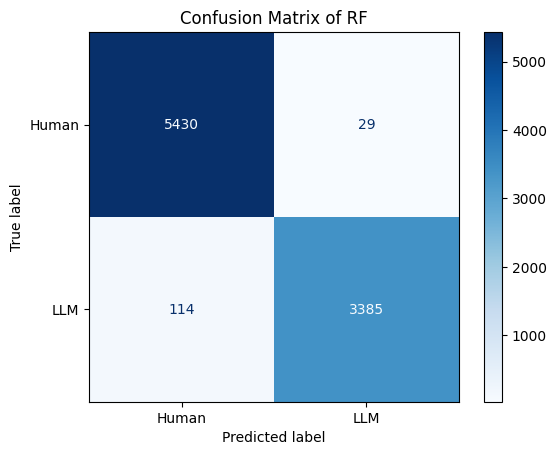

In [ ]:
from sklearn.ensemble import RandomForestClassifier


rf_model = RandomForestClassifier(
    n_estimators=100,       # 100 trees (standard)
    class_weight='balanced', # Handle class imbalance
    random_state=42
)

# train the model
rf_model.fit(X_train, y_train)

# predict on the test set
y_pred_rf = rf_model.predict(X_test)


print("Classification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf, target_names=["Human", "LLM"]))


cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Human", "LLM"])
disp_rf.plot(cmap='Blues')
plt.title('Confusion Matrix of RF')
plt.show()


##KNN

Classification Report (KNN):
              precision    recall  f1-score   support

       Human       0.99      0.98      0.98      5459
         LLM       0.97      0.98      0.97      3499

    accuracy                           0.98      8958
   macro avg       0.98      0.98      0.98      8958
weighted avg       0.98      0.98      0.98      8958



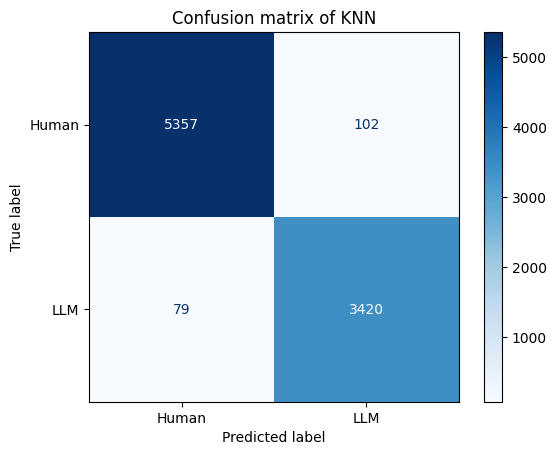

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(
    n_neighbors=5,  # i can tune it
    n_jobs=-1       # use all CPU cores for faster computation
)


knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)

print("Classification Report (KNN):")
print(classification_report(y_test, y_pred_knn, target_names=["Human", "LLM"]))


cm_knn = confusion_matrix(y_test, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=["Human", "LLM"])
disp_knn.plot(cmap='Blues')
plt.title('Confusion matrix of KNN')
plt.show()


##Naive Bayes

Classification report (NB):
              precision    recall  f1-score   support

       Human       0.96      0.98      0.97      5459
         LLM       0.97      0.94      0.95      3499

    accuracy                           0.96      8958
   macro avg       0.97      0.96      0.96      8958
weighted avg       0.96      0.96      0.96      8958



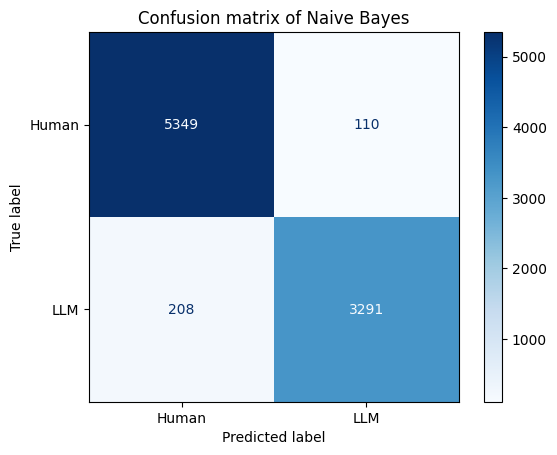

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()


nb_model.fit(X_train, y_train)


y_pred_nb = nb_model.predict(X_test)


print("Classification report (NB):")
print(classification_report(y_test, y_pred_nb, target_names=["Human", "LLM"]))

cm_nb = confusion_matrix(y_test, y_pred_nb)
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=["Human", "LLM"])
disp_nb.plot(cmap='Blues')
plt.title('Confusion matrix of Naive Bayes')
plt.show()


##MLP

Classification Report (MLP):
              precision    recall  f1-score   support

       Human       0.99      1.00      0.99      5459
         LLM       1.00      0.99      0.99      3499

    accuracy                           0.99      8958
   macro avg       0.99      0.99      0.99      8958
weighted avg       0.99      0.99      0.99      8958



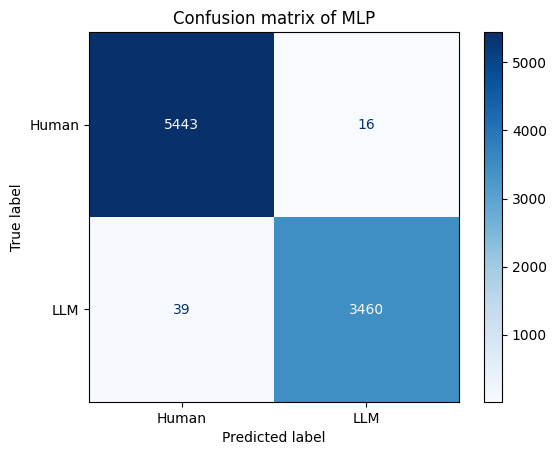

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(
    hidden_layer_sizes=(100,),   # 1 hidden layer with 100 neurons
    max_iter=300,
    random_state=42
)

mlp_model.fit(X_train, y_train)

y_pred_mlp = mlp_model.predict(X_test)

print("Classification Report (MLP):")
print(classification_report(y_test, y_pred_mlp, target_names=["Human", "LLM"]))

cm_mlp = confusion_matrix(y_test, y_pred_mlp)
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=["Human", "LLM"])
disp_mlp.plot(cmap='Blues')
plt.title('Confusion matrix of MLP')
plt.show()


# Evaluate model performance by Bins (200, 500 500+)

In [ ]:
# for this evaluation i need:
#  df_final: full cleaned dataframe (with 'clean_text' and 'word_count')
#  tfidf_vectorizer: the trained TF-IDF vectorizer (with 10000 features)
#  BEST trained models: LR, svm, mlp

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score


# transform the full clean text data to TF-IDF matrix
X_full_tfidf = tfidf_vectorizer.transform(df_final['clean_text'])
y_full = df_final['generated']  # Labels (0 = Human, 1 = LLM)
# save original indices
original_indices = df_final.index
# perform stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_full_tfidf,
    y_full,
    test_size=0.2,
    stratify=y_full,
    random_state=42
)

# split original indices the same way
_, test_indices = train_test_split(
    original_indices,
    test_size=0.2,
    stratify=y_full,
    random_state=42
)

# create df_test from df_final
df_test = df_final.loc[test_indices].copy()
df_test['true_label'] = y_test

#  define word count categoriess

def assign_length_bin(word_count):
    if word_count <= 200:
        return 'Short'
    elif word_count <= 500:
        return 'Medium'
    else:
        return 'Long'

df_test['length_bin'] = df_test['word_count'].apply(assign_length_bin)

#predict with models

# predict on X_test
y_pred_lr = lr_model.predict(X_test)
y_pred_svm = svm_model.predict(X_test)
y_pred_mlp = mlp_model.predict(X_test)
# add predictions to df_test
df_test['pred_lr'] = y_pred_lr
df_test['pred_svm'] = y_pred_svm
df_test['pred_mlp'] = y_pred_mlp

# evaluate performance per categories

results = []

# define models and their prediction columns
model_predictions = [
    ('Logistic Regression', 'pred_lr'),
    ('SVM', 'pred_svm'),
    ('MLP', 'pred_mlp')
]

# loop over models and categories
for model_name, pred_column in model_predictions:
    for bin_label in ['Short', 'Medium', 'Long']:
        subset = df_test[df_test['length_bin'] == bin_label]
        acc = accuracy_score(subset['true_label'], subset[pred_column])
        f1 = f1_score(subset['true_label'], subset[pred_column], pos_label=1)
        results.append({
            'Model': model_name,
            'Text length bin': bin_label,
            'Accuracy': round(acc, 4),
            'F1-score': round(f1, 4)
        })

# plot
results_df = pd.DataFrame(results)
print(results_df)


                 Model Text length bin  Accuracy  F1-score
0  Logistic Regression           Short    0.9891    0.9844
1  Logistic Regression          Medium    0.9906    0.9900
2  Logistic Regression            Long    0.9945    0.9633
3                  SVM           Short    0.9891    0.9845
4                  SVM          Medium    0.9926    0.9921
5                  SVM            Long    0.9969    0.9793
6                  MLP           Short    0.9891    0.9845
7                  MLP          Medium    0.9938    0.9934
8                  MLP            Long    0.9963    0.9752


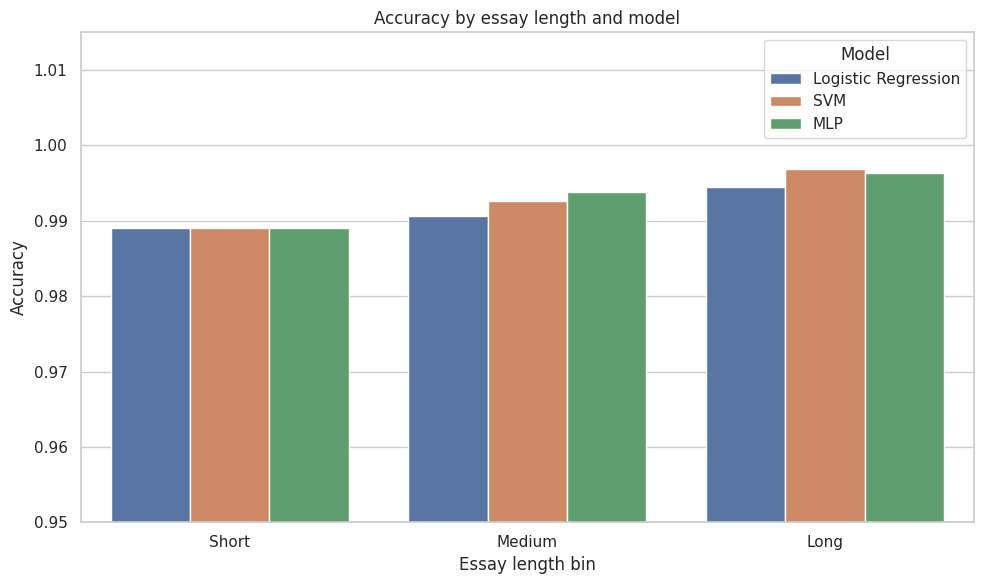

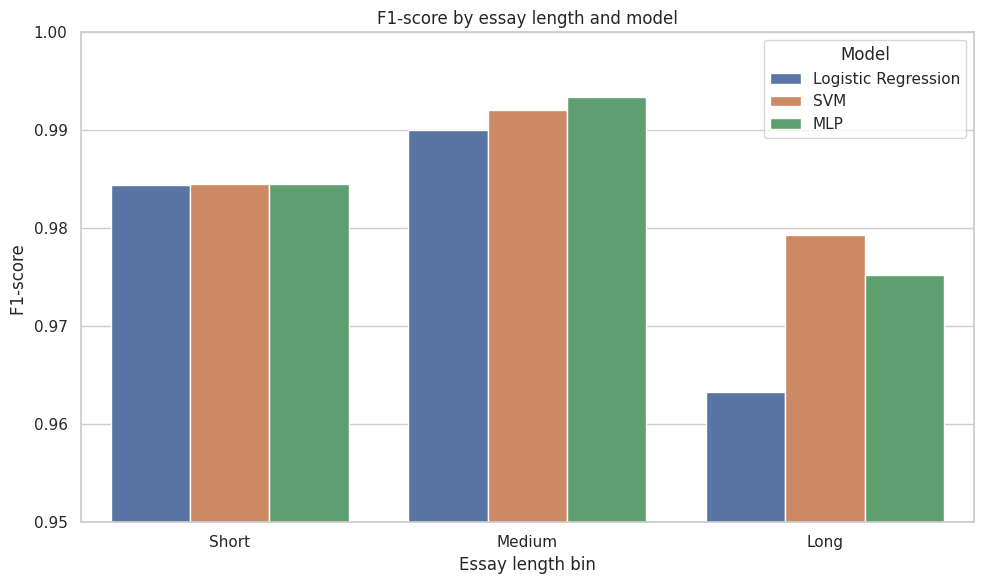

In [ ]:
# visualize results
sns.set(style="whitegrid")

#   Accuracy
plt.figure(figsize=(10,6))
sns.barplot(data=results_df, x='Text length bin', y='Accuracy', hue='Model')
plt.title('Accuracy by essay length and model')
plt.ylim(0.95, 1.015)
plt.ylabel('Accuracy')
plt.xlabel('Essay length bin')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

#  F1-score
plt.figure(figsize=(10,6))
sns.barplot(data=results_df, x='Text length bin', y='F1-score', hue='Model')
plt.title('F1-score by essay length and model')
plt.ylim(0.95, 1.0)
plt.ylabel('F1-score ')
plt.xlabel('Essay length bin')
plt.legend(title='Model')
plt.tight_layout()
plt.show()
